In [1]:
devtools::load_all(".")
library(ggplot2); theme_set(theme_classic(base_size=14))
suppressPackageStartupMessages(library(dplyr))
library(patchwork)
options(repr.plot.res = 200)

ℹ Loading calpred


In [2]:
n_indiv <- 50000

set.seed(1234)

data <- simulate_example(n=n_indiv)
# 10k individuals used in calibration
cal_data <- data[1:10000, ]
# 40k individuals used in testing
test_data <- data[10001:n_indiv, ]

# Example analysis for individual-level trait
Next we present an example workflow for analyzing trait using a simulated data. We hope the pipeline can be easily modified for a real data analysis.

As a recommended practice, we first normalize phenotype distribution to be normal so that it better fits the CalPred assumption. Below we visualize the distribution of phenotype before and after this normalization. The `qref` object can perform normalization to new data and also transform the normalized phenotype into the raw scale after we perform the analysis. 

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”


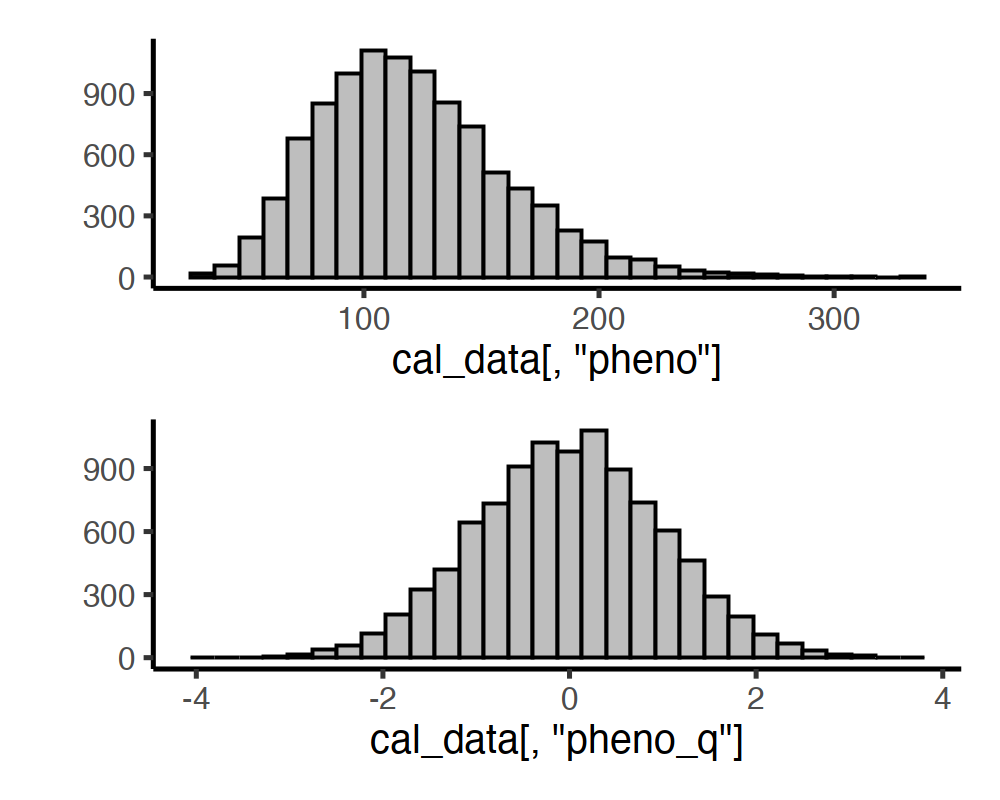

In [3]:
# build reference to convert quantile <-> value using the calibration dataset
qref <- normalize_reference(cal_data[, 'pheno']) 
cal_data['pheno_q'] <- qref$x2q(cal_data[, "pheno"])
test_data['pheno_q'] <- qref$x2q(test_data[, 'pheno'])

options(repr.plot.width = 5, repr.plot.height = 4)

qplot(cal_data[, "pheno"], bins=30, fill=I("grey"), color=I("black")) /
qplot(cal_data[, "pheno_q"], bins=30, fill=I("grey"), color=I("black"))

# Use calibration data to train the model

In [4]:
mean_mat <- as.matrix(cal_data[, c("intercept", "yhat")])
sd_mat <- as.matrix(cal_data[, c("intercept", "ancestry", "age", "sex")])
y <- cal_data[, 'pheno_q']
fit <- train(
    mean_mat=mean_mat, 
    sd_mat=sd_mat, 
    y=y
)

# use calibration data to train the model
mean_mat <- as.matrix(test_data[, c("intercept", "yhat")])
sd_mat <- as.matrix(test_data[, c("intercept", "ancestry", "age", "sex")])
pred <- predict(mean_mat=mean_mat, sd_mat=sd_mat, mean_coef=fit$mean_coef, sd_coef=fit$sd_coef)
pred <- pred %>%
    rowwise() %>%
    mutate(
        point = qref$q2x(mean), 
        low = qref$q2x(mean - sd * 1.645), 
        high = qref$q2x(mean + sd * 1.645)
    )
test_data <- data.frame(test_data, pred)

# Visualize coverage and prediction interval length

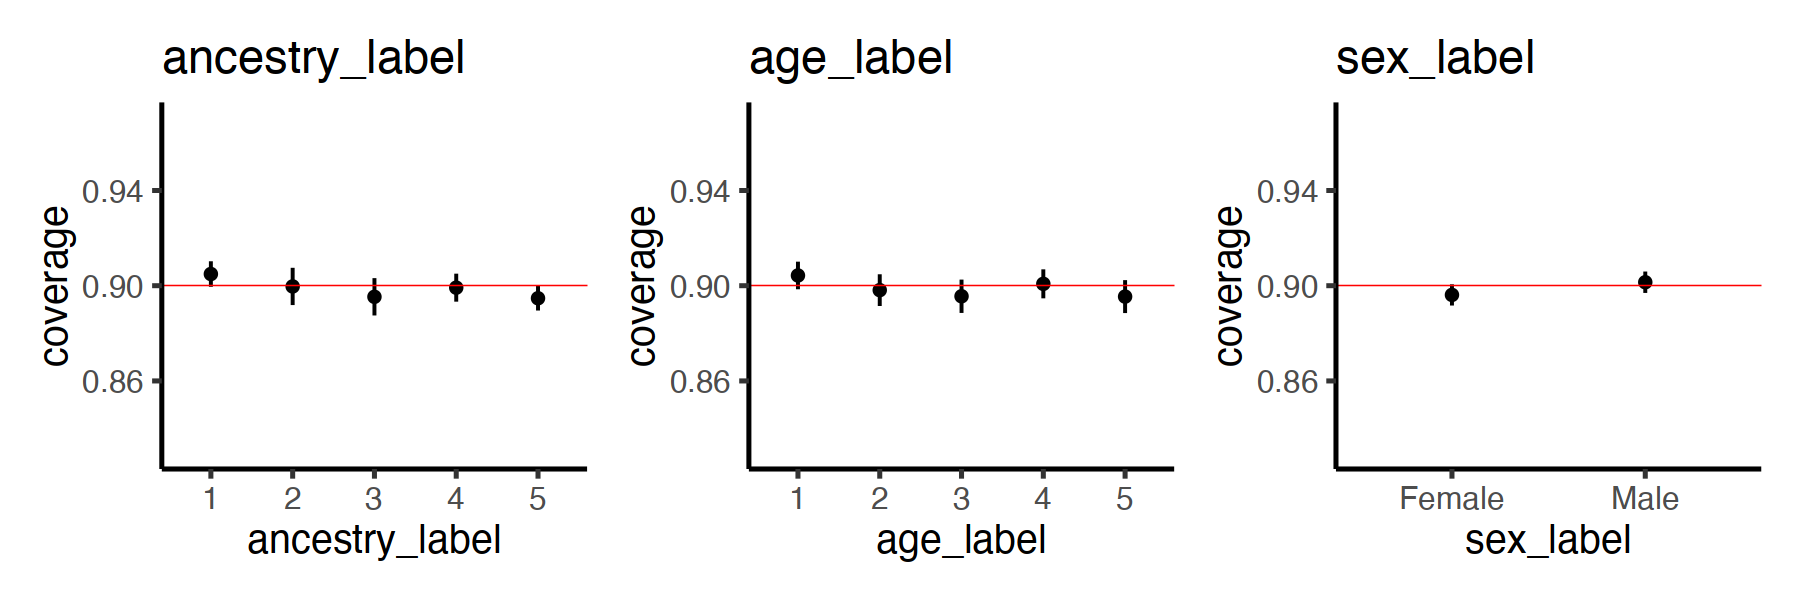

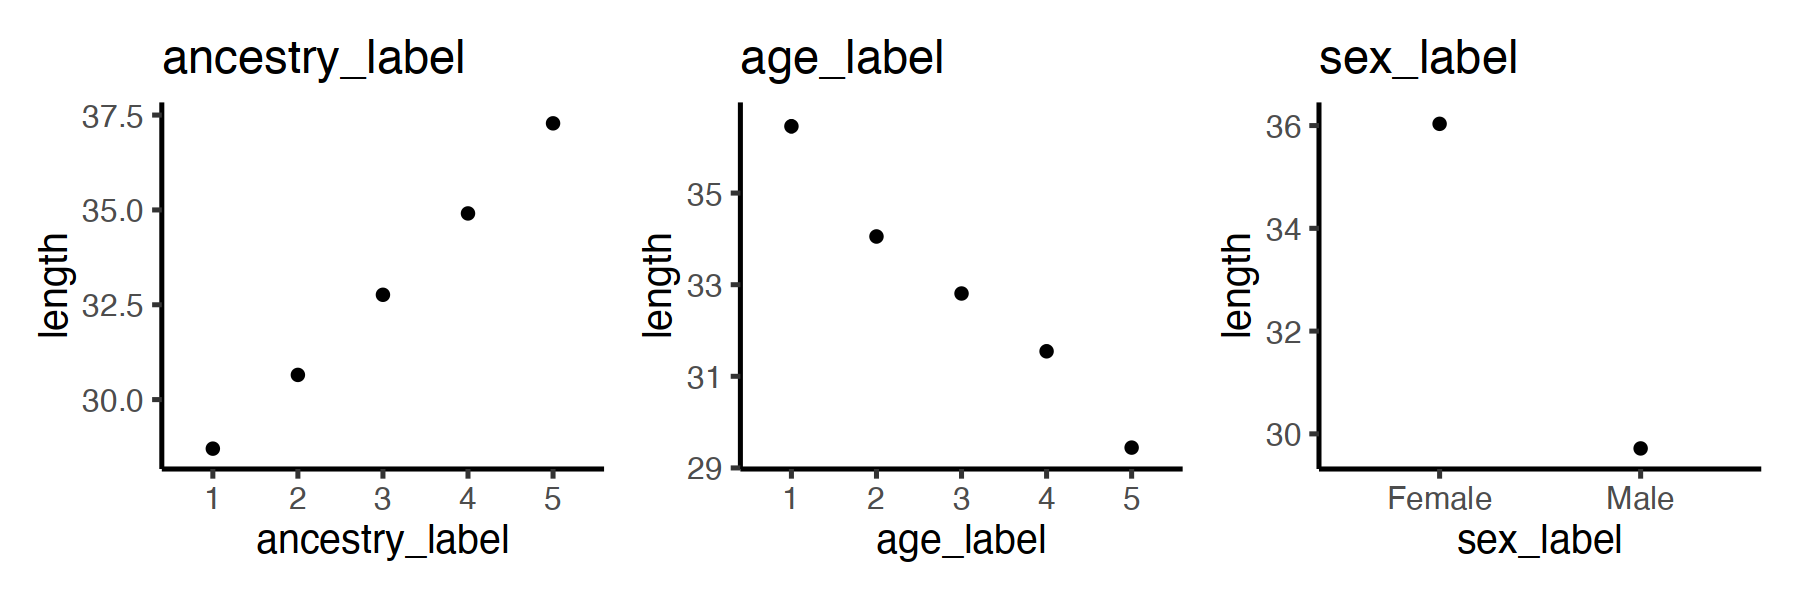

In [5]:
coverage_plots <- list()
length_plots <- list()
for (context in c("ancestry_label", "age_label", "sex_label")) {
        
    stats <- compute_stats(
        y=test_data[, 'pheno'], 
        pred=pred$mean, 
        predlow=pred$low, 
        predhigh=pred$high, 
        group=test_data[, context]
    )
    
    coverage_plots[[context]] <- plot_stats(stats$bootstrap_stats, 'coverage') + 
          labs(title = context, x=context) +
          ylim(0.83, 0.97) + geom_hline(yintercept=0.9, color = "red", linewidth=0.2)
    
    length_plots[[context]] <- plot_stats(stats$bootstrap_stats, 'length') + 
          labs(title = context, x=context)

}

options(repr.plot.width = 9, repr.plot.height = 3)
wrap_plots(coverage_plots, ncol = 3)
wrap_plots(length_plots, ncol = 3)

# Top 5 individuals with shorted/highest prediction intervals
We note these individuals are characterized by their ancestry, age, and sex according to their effects to accuracy.

In [6]:
test_data[order(test_data$sd)[1:5], ]

,yhat,intercept,ancestry,age,sex,ancestry_label,age_label,sex_label,y,pheno,pheno_q,mean,sd,point,low,high
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
36558,0.7726636,1,-1.681603,3.378684,-0.9938489,1,5,Male,1.8659366,161,1.0175329,0.4129401,0.5056843,132.96223,100.34923,171.9685
46547,0.4397957,1,-1.172112,3.642357,-0.9938489,1,5,Male,-0.8697438,98,-0.4894827,0.2324742,0.5196382,125.12369,93.49865,164.1727
21913,-1.2509055,1,-1.655917,3.019639,-0.9938489,1,5,Male,-0.5483730,105,-0.2982662,-0.6841477,0.5204023,91.51453,66.66358,122.5074
11188,-0.5703067,1,-1.598611,3.000470,-0.9938489,1,5,Male,-1.6034111,85,-0.8841782,-0.3151578,0.5238713,104.42967,76.54646,138.3650
44672,0.5833130,1,-1.703870,2.766413,-0.9938489,1,5,Male,3.1407244,195,1.6823551,0.3102828,0.5278425,128.53935,95.60570,168.5258


In [7]:
test_data[order(test_data$sd, decreasing = TRUE)[1:5], ]

,yhat,intercept,ancestry,age,sex,ancestry_label,age_label,sex_label,y,pheno,pheno_q,mean,sd,point,low,high
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
15617,-0.9740949,1,1.6747580,-3.196340,1.006169,5,1,Female,1.9853981,164,1.08369512,-0.5340735,1.340733,96.50677,40.43031,194.2853
22915,0.1161143,1,1.6547685,-3.000600,1.006169,5,1,Female,0.4126951,125,0.22921733,0.0569887,1.319204,118.18340,53.69919,225.8239
18474,0.2943588,1,0.8990467,-3.936318,1.006169,4,1,Female,-1.4335745,88,-0.79347694,0.1536249,1.318652,121.74689,55.68651,232.0208
13442,-0.6199449,1,1.6904665,-2.817993,1.006169,5,1,Female,-2.4310439,72,-1.33860284,-0.3420693,1.305902,103.44661,45.20178,201.5904
16424,-1.8496616,1,1.3886061,-3.192082,1.006169,5,1,Female,-0.0989219,114,-0.05467172,-1.0087663,1.305716,81.62337,33.62703,166.6838


# Visualizing individualized prediction
We then visualize individuals with point predictions from 120-125, retrieve 10 individuals with largest SDs and 10 individuals with smallest SDs.

In [8]:
# Extract data
df <- test_data %>% filter((120 < point) & (point < 125))
df <- rbind(
    df %>% top_n(-10, sd),
    df %>% top_n(10, sd)
)
df[, "index"] <- 1 : nrow(df)

In [9]:
library(ggnewscale)

p <- ggplot(df, aes(x = index, y = point)) +
  geom_errorbar(aes(ymin = low, ymax = high), width = 0) +
  geom_point(size = 3) +
  geom_hline(yintercept=100, color='red') +
  labs(y="Predicted phenotype") +
  theme(axis.line.x = element_blank(), axis.ticks.x = element_blank(), axis.text.x=element_blank(), axis.title.x = element_blank()) +
  ylim(0, 250) +
  xlim(0, 23)

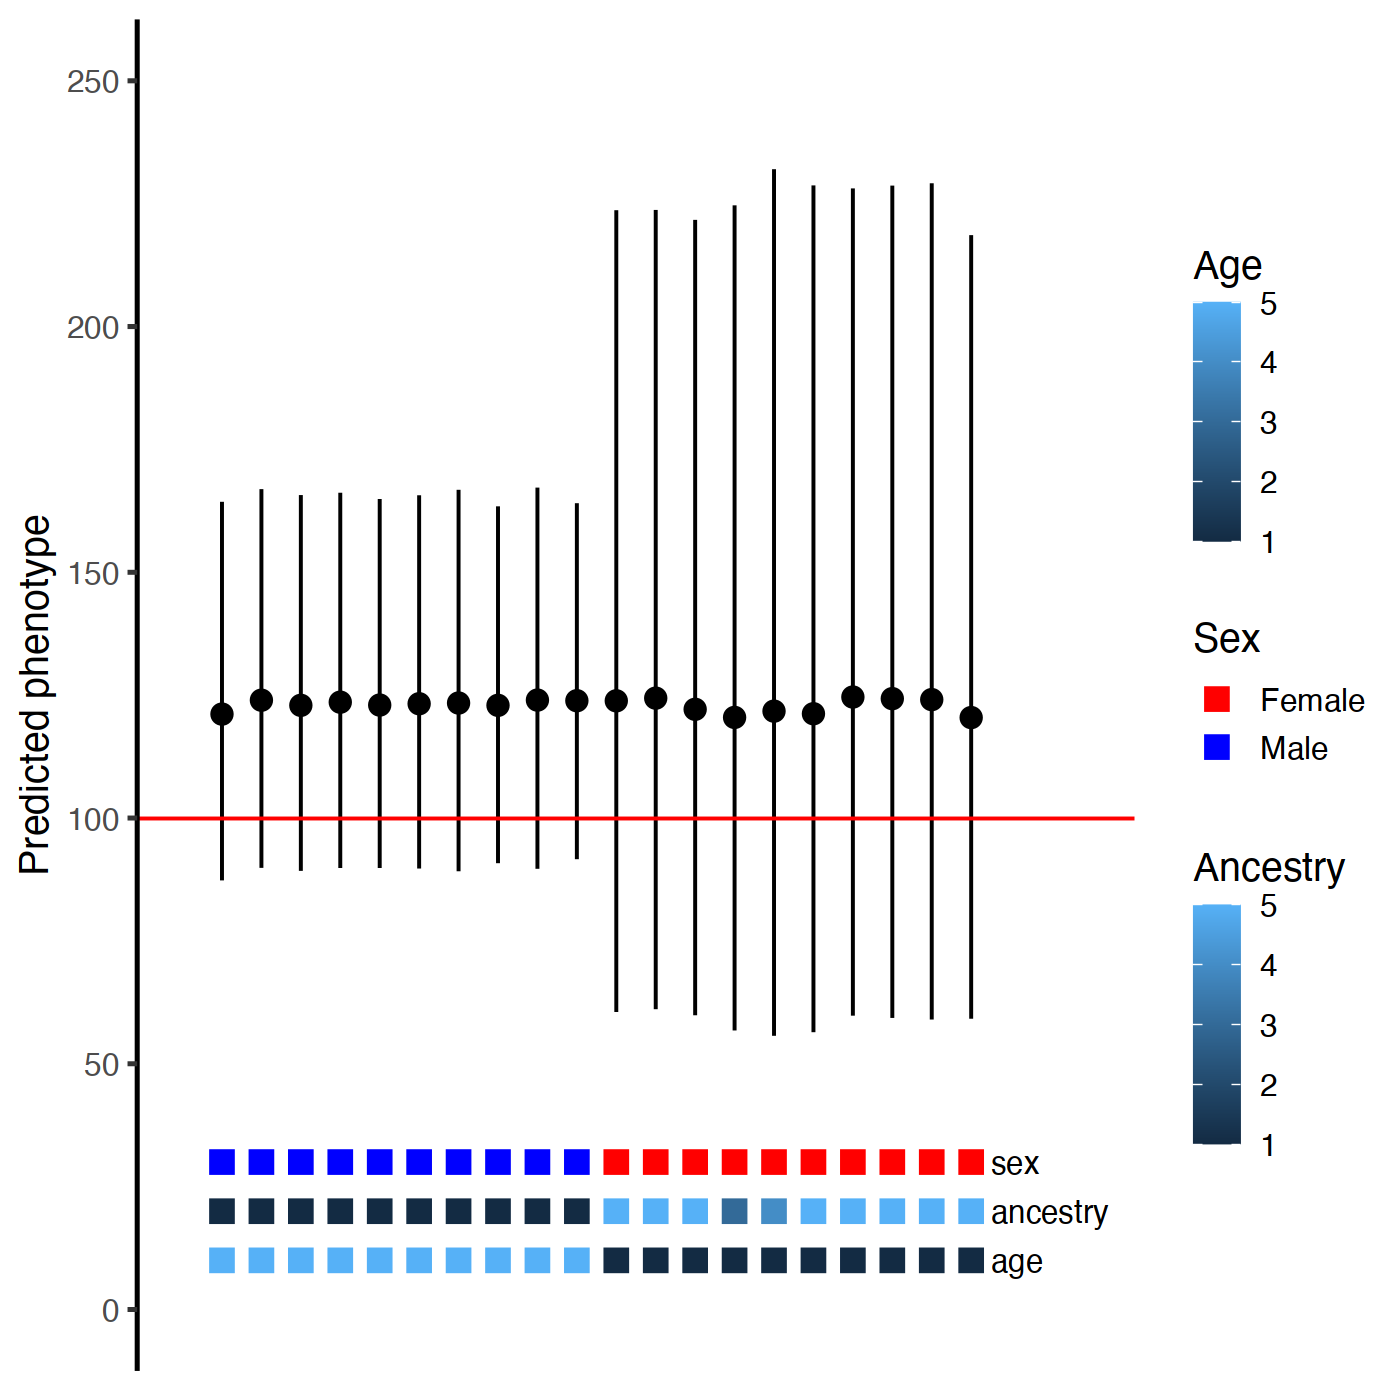

In [10]:
options(repr.plot.width = 7, repr.plot.height = 7)

p + 
geom_point(
    x=df$index,
    y=30,
    shape='square',
    aes(color=sex_label),
    size=4
) +
annotate(geom="text", x=20.5, y=30, label="sex", hjust=0) +
scale_color_manual(name = "Sex", values=c("Red", "Blue")) +
new_scale_color() +
geom_point(
    x=df$index,
    y=20,
    shape='square',
    aes(color=ancestry_label),
    size=4
) +
annotate(geom="text", x=20.5, y=20, label="ancestry", hjust = 0) + 
scale_colour_gradient(name = "Ancestry") +
new_scale_color() +
geom_point(
    x=df$index,
    y=10,
    shape='square',
    aes(color=age_label),
    size=4
) +
annotate(geom="text", x=20.5, y=10, label="age", hjust = 0) +
scale_colour_gradient(name = "Age")

We have several observations:
1. The prediction interval length differ by a significant amount for these two groups of individuals, even all of them have similar point predictions.
2. Individuals with large standard deviation are characterized by their sex, ancestry and according to how these contexts impact accuracy (quantified by $\beta_\sigma$).